<a href="https://colab.research.google.com/github/Osterne/codes_podcast/blob/main/episodio_04_metricas_modelos_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

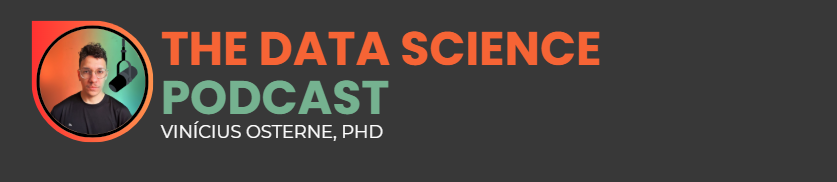


# Episódio 04 - Métricas para modelos de classificação

## Dúvida de um seguidor

“Professor, eu vejo que em modelos de classificação sempre falam de acurácia, precisão, recall, sensibilidade, especificidade… mas eu nunca sei qual delas usar. Por exemplo, se eu tenho um modelo para detectar fraude, qual métrica eu devo priorizar? E por que não basta olhar só a acurácia?”

## Análise

In [1]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [3]:
# ===============================
# Base artificial mais difícil
# ===============================
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 2000

# Variáveis comportamentais
transacoes_24h = np.random.poisson(lam=2, size=n_samples)               # discreta
dispositivos = np.random.randint(1, 5, n_samples)                       # discreta
tentativas_senha = np.random.poisson(lam=1, size=n_samples)              # discreta

# Variáveis contínuas
tempo_sessao = np.random.exponential(scale=300, size=n_samples)          # tempo de sessão em segundos
valor_medio_transacao = np.random.normal(loc=500, scale=200, size=n_samples)  # valor médio em R$

# Ajuste para manter valores positivos
valor_medio_transacao = np.clip(valor_medio_transacao, 50, None)

# Probabilidade base de fraude
prob_fraude = (
    0.05 +
    0.15 * (tentativas_senha > 2) +
    0.10 * (dispositivos > 2) +
    0.08 * (transacoes_24h < 1) +
    0.10 * (tempo_sessao > 800) +
    0.12 * (valor_medio_transacao > 1000)
)

# Limitando probabilidade entre 0 e 0.95
prob_fraude = np.clip(prob_fraude, 0, 0.95)

# Sorteando fraude com base na probabilidade (ruído incluído)
fraude = np.random.binomial(1, prob_fraude)

# Criar DataFrame
df = pd.DataFrame({
    'transacoes_24h': transacoes_24h,
    'dispositivos': dispositivos,
    'tentativas_senha': tentativas_senha,
    'tempo_sessao': tempo_sessao,
    'valor_medio_transacao': valor_medio_transacao,
    'fraude': fraude
})

print(df['fraude'].mean())  # Taxa média de fraude (~15-25%)
print(df.shape)


0.13
(2000, 6)


In [4]:
#transacoes_24h: número de transações nas últimas 24h (detecta padrões anormais de atividade)
#dispositivos: número de dispositivos diferentes usados para login (Indica possível comprometimento de conta)
#tentativas_senha: tentativas de senha incorreta (Comportamento típico de ataques ou fraude)
#tempo_sessao: tempo de sessão (Tempo de uso em segundos)
#valor_medio_transacao: valor medio da transação (valor médio do ticket solicitado em R$)

df.head(5)

,transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,fraude
0,4,3,1,662.496647,50.000000,0
1,1,1,1,587.797207,499.227544,0
2,3,2,0,23.949215,385.474599,0
3,3,4,0,33.745217,529.163620,0
4,1,1,1,205.061008,718.525513,0


In [5]:
# ===============================
# Treinar modelo GBM
# ===============================
# Iniciar H2O
h2o.init()

# Converter o dataframe para H2OFrame
hf = h2o.H2OFrame(df)

# Definir features e target (agora incluindo as contínuas)
features = [
    'transacoes_24h',
    'dispositivos',
    'tentativas_senha',
    'tempo_sessao',
    'valor_medio_transacao'
]
target = 'fraude'

# Converter target para categórico (fator)
hf[target] = hf[target].asfactor()

# Treinar modelo GBM
gbm_model = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=3,
    learn_rate=0.1,
    seed=42
)
gbm_model.train(x=features, y=target, training_frame=hf)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyoc6t769
  JVM stdout: /tmp/tmpyoc6t769/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyoc6t769/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_18q4va
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1754074453326_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         14533                  3            3            3             4             8             6.91

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09073706034788907
RMSE: 0.30122592907631485
LogLoss: 0.30470785683944324
Mean Per-Class Error: 0.2723032714412025
AUC: 0.8349535809018567
AUCPR: 0.5037986648065483
Gini: 0.6699071618037133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20329613365414523
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1562  178  0.1023   (178.0/1740.0)
1      115   145  0.4423   (115.0/260.0)
Total  1677  323  0.1465   (293.0/2000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.203296     0.497427  151
max f2                       0.145969     0.597484  215
max f0point5                 0.274163     0.526316  98
max accuracy                 0.405463     0.8855    40
max precision                0.803318     1         0
max recall                   0.0332314    1         369
max specificity              0.803318     1         0
max absolute_mcc             0.203296     0.416179  151
max min_per_class_accuracy   0.156554     0.746154  203
max mean_per_class_accuracy  0.145969     0.758245  215
max tns                      0.803318     1740      0
max fns                      0.803318     259       0
max fps                      0.00737087   1740      399
max tps                      0.0332314    260       369
max tnr                      0.803318     1         0
max fnr                      0.803318     0.996154  0
max fpr                      0.00737087   1         399
max tpr                      0.0332314    1         369

Gains/Lift Table: Avg response rate: 13.00 %, avg score: 13.01 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.518635           7.30769    7.30769            0.95             0.59709    0.95                        0.59709             0.0730769       0.0730769                  630.769   630.769            0.0725022
2        0.02                        0.44598            5.76923    6.53846            0.75             0.47845    0.85                        0.53777             0.0576923       0.130769                   476.923   553.846            0.127321
3        0.03                        0.388075           3.84615    5.64103            0.5              0.419158   0.733333                    0.498233            0.0384615       0.169231                   284.615   464.103            0.160035
4        0.04                        0.364024           3.84615    5.19231            0.5              0.376916   0.675                       0.467903            0.0384615       0.207692                   284.615   419.231            0.19275
5        0.05                        0.327724           3.07692    4.76923            0.4              0.343146   0.62                        0.442952

In [6]:
# ===============================
# 4. Importância das variáveis
# ===============================
# Importância das variáveis
importancia = gbm_model.varimp(use_pandas=True)

# Mostrar
print(importancia)

                variable  relative_importance  scaled_importance  percentage
0  valor_medio_transacao            61.042236           1.000000    0.300240
1           tempo_sessao            59.690277           0.977852    0.293590
2           dispositivos            34.509418           0.565337    0.169737
3       tentativas_senha            26.404104           0.432555    0.129870
4         transacoes_24h            21.665323           0.354923    0.106562


In [ ]:
# ===============================
# 5. Métricas de avaliação
# ===============================

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, matthews_corrcoef, cohen_kappa_score,
    balanced_accuracy_score, roc_curve
)

In [8]:
# Obter probabilidades de fraude
preds = gbm_model.predict(hf).as_data_frame()
y_true = df['fraude']
y_pred = preds['predict'].astype(int)
y_proba = preds['p1']  # probabilidade da classe fraude

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
# ================================================
# Acurácia
# ================================================
# Como se calcula: (Verdadeiros Positivos + Verdadeiros Negativos) / Total de observações.
# Vantagem? Simples de interpretar, mostra % de acertos gerais.
# Desvantagem? Enganosa em classes desbalanceadas (ex: 99% não fraude → 99% de acurácia mesmo sem detectar fraude).
# Quando não usar? Problemas com classe rara (fraude).
# Quando usar? Classes balanceadas ou como métrica complementar.
# O que pode melhorar essa métrica? Usar Balanced Accuracy ou F1-score.
# Cuidado? Não usar isoladamente em bases desbalanceadas.
# Valor ideal:
#   - < 0.70 → Ruim
#   - 0.70 a 0.85 → Regular
#   - > 0.85 → Bom (se não houver desbalanceamento)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8535


In [16]:
# ================================================
# Precisão
# ================================================
# Como se calcula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos).
# Vantagem? Mede quão confiáveis são as previsões de fraude.
# Desvantagem? Pode ser alta mesmo ignorando muitas fraudes (baixo recall).
# Quando não usar? Quando prioridade é detectar todas as fraudes.
# Quando usar? Quando falsos positivos são caros (ex: bloquear clientes bons).
# O que pode melhorar essa métrica? Ajustar limiar de decisão, balancear dataset.
# Cuidado? Alta precisão pode vir às custas de baixo recall.
# Valor ideal:
#   - < 0.60 → Ruim
#   - 0.60 a 0.80 → Regular
#   - > 0.80 → Bom
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

Precision: 0.4485981308411215


In [17]:
# ================================================
# Recall (Sensibilidade)
# ================================================
# Como se calcula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos).
# Vantagem? Mede a capacidade do modelo em capturar fraudes reais.
# Desvantagem? Pode gerar muitos falsos positivos.
# Quando não usar? Quando falsos positivos têm custo alto.
# Quando usar? Segurança, saúde, fraudes – não podemos perder eventos.
# O que pode melhorar essa métrica? Ajustar cutoff, balancear dataset.
# Cuidado? Alto recall pode vir com baixa precisão.
# Valor ideal:
#   - < 0.60 → Ruim
#   - 0.60 a 0.80 → Regular
#   - > 0.80 → Bom
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

Recall: 0.5538461538461539


In [18]:
# ================================================
# F1-Score
# ================================================
# Como se calcula: 2 * (Precisão * Recall) / (Precisão + Recall).
# Vantagem? Equilibra precisão e recall em uma métrica única.
# Desvantagem? Pode esconder desempenho ruim em uma das métricas.
# Quando não usar? Quando uma métrica é claramente prioritária.
# Quando usar? Classes desbalanceadas com necessidade de equilíbrio.
# O que pode melhorar essa métrica? Ajuste de threshold e reamostragem.
# Cuidado? Interprete junto com precisão e recall.
# Valor ideal:
#   - < 0.60 → Ruim
#   - 0.60 a 0.80 → Regular
#   - > 0.80 → Bom
f1 = f1_score(y_true, y_pred)
print("F1-Score:", f1)

F1-Score: 0.49569707401032703


In [19]:
# ================================================
# ROC AUC
# ================================================
# Como se calcula: Área sob a curva ROC (Taxa de Verdadeiros Positivos vs Taxa de Falsos Positivos).
# Vantagem? Avalia separação entre classes sem depender de cutoff.
# Desvantagem? Pode ser enganosa em bases com evento raro.
# Quando não usar? Fraude ou eventos raros – prefira PR AUC.
# Quando usar? Comparar modelos em classificação binária.
# O que pode melhorar essa métrica? Melhorar features e discriminação do modelo.
# Cuidado? ROC AUC alto não garante bom recall.
# Valor ideal:
#   - < 0.70 → Fraco
#   - 0.70 a 0.85 → Bom
#   - > 0.85 → Excelente
roc_auc = roc_auc_score(y_true, y_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.8349778956675509


ROC AUC: 0.8349778956675509


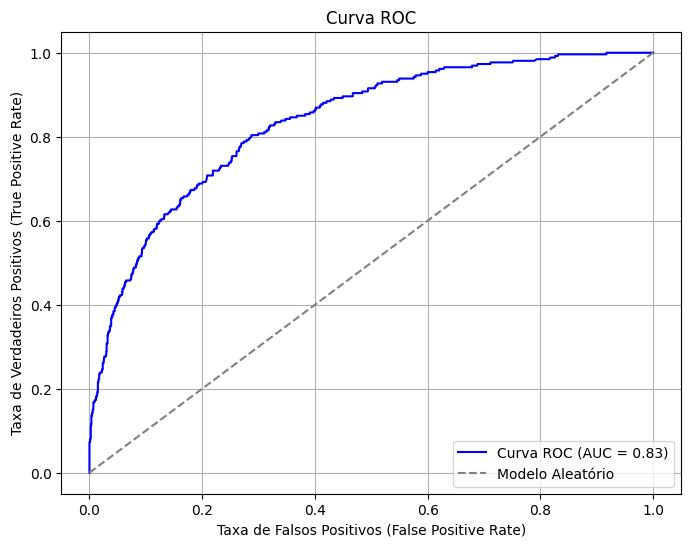

In [20]:
# ================================================
# Curva ROC e ROC AUC
# ================================================
# Como se calcula: Área sob a curva ROC que compara a Taxa de Verdadeiros Positivos (TPR)
#                  com a Taxa de Falsos Positivos (FPR) em diferentes limiares.
# Vantagem? Avalia a capacidade do modelo em separar classes independentemente do cutoff.
# Desvantagem? Pode ser otimista em datasets com eventos raros (classe positiva muito pequena).
# Quando não usar? Bases muito desbalanceadas (prefira PR AUC).
# Quando usar? Avaliar modelos binários, comparar classificadores.
# O que pode melhorar essa métrica? Melhorar engenharia de features, ajustar hiperparâmetros.
# Cuidado? ROC AUC alto não garante bom recall ou boa precisão.
# Valor ideal:
#   - < 0.70 → Fraco
#   - 0.70 a 0.85 → Bom
#   - > 0.85 → Excelente

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_true, y_proba)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Modelo Aleatório')
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

PR AUC: 0.5049293141687562


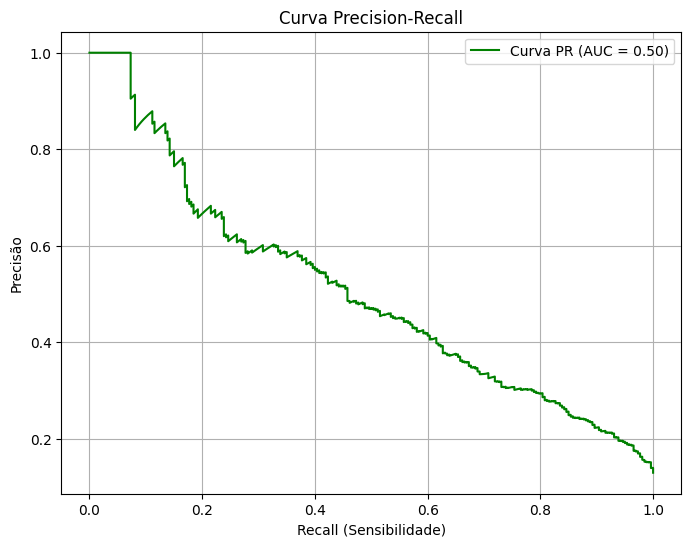

In [22]:
# ================================================
# Curva Precision-Recall (PR) e PR AUC
# ================================================
# Como se calcula: Área sob a curva de Precisão (TP / (TP + FP))
#                  versus Recall (TP / (TP + FN)) em diferentes limiares.
# Vantagem? Foca na classe positiva (fraude), melhor que ROC AUC em problemas desbalanceados.
# Desvantagem? Menos intuitivo para não técnicos, pode variar muito em datasets pequenos.
# Quando não usar? Classes balanceadas (ROC AUC já é suficiente).
# Quando usar? Detecção de fraudes, churn, diagnósticos médicos – quando a classe positiva é rara.
# O que pode melhorar essa métrica? Ajuste do cutoff, engenharia de features, técnicas de balanceamento.
# Cuidado? Não comparar diretamente PR AUC de bases com prevalências muito diferentes.
# Valor ideal:
#   - < 0.50 → Fraco
#   - 0.50 a 0.75 → Bom
#   - > 0.75 → Excelente

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

pr_auc = average_precision_score(y_true, y_proba)
print("PR AUC:", pr_auc)

precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Curva PR (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [23]:
# ================================================
# KS Statistic
# ================================================
# Como se calcula: Máxima diferença entre Taxa de Verdadeiros Positivos e Taxa de Falsos Positivos.
# Vantagem? Muito usado em risco de crédito e fraude.
# Desvantagem? Não reflete custos diretamente.
# Quando não usar? Quando importância de FP ≠ FN.
# Quando usar? Scorecards, modelos de risco binários.
# O que pode melhorar essa métrica? Variáveis que separem melhor classes.
# Cuidado? KS no último decil = 0; use valor máximo.
# Valor ideal:
#   - < 0.30 → Fraco
#   - 0.30 a 0.50 → Bom
#   - > 0.50 → Excelente
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
ks = max(tpr - fpr)
print("KS:", ks)

KS: 0.5164898320070734


In [24]:
# ================================================
# Cohen's Kappa
# ================================================
# Como se calcula: (Acurácia observada - Acurácia esperada) / (1 - Acurácia esperada).
# Vantagem? Mede concordância ajustada ao acaso.
# Desvantagem? Menos intuitiva que outras métricas.
# Quando não usar? Quando o público é não técnico.
# Quando usar? Auditoria de classificadores.
# O que pode melhorar essa métrica? Balanceamento da base.
# Cuidado? Interprete junto com outras métricas.
# Valor ideal:
#   - < 0.20 → Fraco
#   - 0.20 a 0.60 → Moderado
#   - > 0.60 → Forte
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.4111026249145797


In [25]:
# ================================================
# Balanced Accuracy
# ================================================
# Como se calcula: Média do recall de cada classe.
# Vantagem? Corrige acurácia em bases desbalanceadas.
# Desvantagem? Não mostra trade-offs de custo.
# Quando não usar? Classes balanceadas.
# Quando usar? Detecção de fraude ou evento raro.
# O que pode melhorar essa métrica? Ajustar pesos do modelo.
# Cuidado? Verificar recall individual.
# Valor ideal:
#   - < 0.70 → Fraco
#   - 0.70 a 0.85 → Bom
#   - > 0.85 → Excelente
bal_acc = balanced_accuracy_score(y_true, y_pred)
print("Balanced Accuracy:", bal_acc)

Balanced Accuracy: 0.7260610079575597


In [26]:
# ================================================
# Matriz de Confusão
# ================================================
# Como se calcula: Tabela que mostra:
#  - Verdadeiros Negativos: previu não fraude e era não fraude
#  - Falsos Positivos: previu fraude mas era não fraude
#  - Falsos Negativos: previu não fraude mas era fraude
#  - Verdadeiros Positivos: previu fraude e era fraude
# Vantagem? Detalha erros e acertos.
# Desvantagem? Não resume em uma única métrica.
# Quando usar? Sempre, para entender padrões de erro.
# O que pode melhorar essa métrica? Ajuste de cutoff, balanceamento.
# Cuidado? Avaliar junto com outras métricas.
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", cm)

Matriz de Confusão:
 [[1563  177]
 [ 116  144]]


In [27]:
# ================================================
# Classification Report
# ================================================
# Como se calcula: Mostra precisão, recall e F1 para cada classe (fraude e não fraude).
# Vantagem? Visão completa por classe.
# Desvantagem? Pode confundir iniciantes.
# Quando usar? Para resumo detalhado de classificação.
# O que pode melhorar essa métrica? Ajustes no cutoff e reamostragem.
# Cuidado? Verifique suporte (número de amostras por classe).
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      1740
           1       0.45      0.55      0.50       260

    accuracy                           0.85      2000
   macro avg       0.69      0.73      0.70      2000
weighted avg       0.87      0.85      0.86      2000

